In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = lambda x: f"{x:,.6f}"

# Annualize
MONTHS_PER_YEAR = 12
def ann_mean(monthly_mean):
    return monthly_mean * MONTHS_PER_YEAR

def ann_vol(monthly_vol):
    return monthly_vol * np.sqrt(MONTHS_PER_YEAR)

def ann_sharpe(monthly_mean, monthly_vol):
    sr_m = monthly_mean / monthly_vol
    return sr_m * np.sqrt(MONTHS_PER_YEAR)

def sharpe_from_ann(mu_ann, vol_ann):
    return mu_ann / vol_ann

def tangency_weights(mu_m, Sigma_m):
    # Max-Sharpe (tangency) portfolio on the risky set with sum of weights = 1

    invS = np.linalg.inv(Sigma_m)
    ones = np.ones(len(mu_m))
    w_unnorm = invS @ mu_m
    k = 1.0 / (ones @ w_unnorm) # normalize s.t. sum(w) = 1
    return k * w_unnorm # (n,)


In [ ]:
path = "/content/multi_asset_etf_data.xlsx"
xls = pd.ExcelFile(path)
tabs = {name.lower(): name for name in xls.sheet_names}
desc = pd.read_excel(path, sheet_name=tabs["descriptions"])
excess = pd.read_excel(path, sheet_name=tabs["excess returns"], index_col=0, parse_dates=True)
excess = excess.drop(columns=["QAI"])

# print("Excess returns shape:", excess.shape)
# excess.head(3)

Q1: Calculate and display the mean and volatility of each asset’s excess return.
Which assets have the best and worst Sharpe ratios?

In [ ]:
# Monthly stats
mu_m = excess.mean(axis=0) # (n,)
vol_m = excess.std(axis=0, ddof=1) # (n,)

# Annualized
mu_ann = ann_mean(mu_m)
vol_ann = ann_vol(vol_m)
sr_ann = ann_sharpe(mu_m, vol_m)

output = pd.DataFrame({
    "Annual Excess Mean": mu_ann,
    "Annual Vol": vol_ann,
    "Annual Sharpe": sr_ann
}).sort_values("Annual Sharpe", ascending=False)

display(output)

best_asset  = output["Annual Sharpe"].idxmax()
worst_asset = output["Annual Sharpe"].idxmin()
print(f"\nBest Sharpe:  {best_asset}  ({output.loc[best_asset, 'Annual Sharpe']:.3f})")
print(f"Worst Sharpe: {worst_asset} ({output.loc[worst_asset, 'Annual Sharpe']:.3f})")

,Annual Excess Mean,Annual Vol,Annual Sharpe
SPY,0.128141,0.142839,0.897103
HYG,0.041371,0.075928,0.544873
IYR,0.074916,0.168675,0.444143
PSP,0.092561,0.213370,0.433804
EFA,0.061775,0.150903,0.409372
TIP,0.020502,0.051115,0.401091
IEF,0.016404,0.063442,0.258569
EEM,0.029339,0.176164,0.166542
DBC,-0.005292,0.166553,-0.031774
BWX,-0.007716,0.082789,-0.093202



Best Sharpe:  SPY  (0.897)
Worst Sharpe: BWX (-0.093)


Q2: Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

In [ ]:
# Correlation of returns
corr = excess.corr()
display(corr)

# Highest + lowest pair
corr_stack = corr.where(~np.eye(len(corr), dtype=bool)).stack()
hi_pair = corr_stack.idxmax()
lo_pair = corr_stack.idxmin()
print(f"Highest cor: {hi_pair} = {corr_stack.loc[hi_pair]:.3f}")
print(f"Lowest cor: {lo_pair} = {corr_stack.loc[lo_pair]:.3f}")

# TIPS performance vs domestic & foreign bonds
tips_col = 'TIP'
dom_bond = 'IEF'
for_bond = 'BWX'

def perf_row(col_name):
    m, v = mu_m[col_name], vol_m[col_name]
    return pd.Series({"annual mean": ann_mean(m), "annual vol": ann_vol(v), "annual sharpe": ann_sharpe(m, v)}, name=col_name)

tips_perf = perf_row(tips_col)
dom_perf  = perf_row(dom_bond)
for_perf  = perf_row(for_bond)

tips_compare = pd.DataFrame([tips_perf, dom_perf, for_perf])
display(tips_compare)

print(f"TIPS vs Domestic Bonds (annual mean): {tips_perf['annual mean']:.3f} vs {dom_perf['annual mean']:.3f}")
print(f"TIPS vs Foreign Bonds  (annual mean): {tips_perf['annual mean']:.3f} vs {for_perf['annual mean']:.3f}")


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,SPY,TIP
BWX,1.000000,0.191116,0.621673,0.602820,0.602555,0.580891,0.552557,0.526692,0.439994,0.675151
DBC,0.191116,1.000000,0.511667,0.500922,0.461887,-0.300207,0.280518,0.453303,0.432162,0.109006
EEM,0.621673,0.511667,1.000000,0.819925,0.691167,0.026704,0.584063,0.750109,0.687751,0.378792
EFA,0.602820,0.500922,0.819925,1.000000,0.787191,0.042639,0.699292,0.895320,0.845863,0.394821
HYG,0.602555,0.461887,0.691167,0.787191,1.000000,0.187258,0.739356,0.812157,0.793518,0.538648
IEF,0.580891,-0.300207,0.026704,0.042639,0.187258,1.000000,0.316532,0.022436,0.000815,0.754102
IYR,0.552557,0.280518,0.584063,0.699292,0.739356,0.316532,1.000000,0.749836,0.754711,0.598742
PSP,0.526692,0.453303,0.750109,0.895320,0.812157,0.022436,0.749836,1.000000,0.891687,0.408005
SPY,0.439994,0.432162,0.687751,0.845863,0.793518,0.000815,0.754711,0.891687,1.000000,0.381625
TIP,0.675151,0.109006,0.378792,0.394821,0.538648,0.754102,0.598742,0.408005,0.381625,1.000000


Highest cor: ('EFA', 'PSP') = 0.895
Lowest cor: ('DBC', 'IEF') = -0.300


,annual mean,annual vol,annual sharpe
TIP,0.020502,0.051115,0.401091
IEF,0.016404,0.063442,0.258569
BWX,-0.007716,0.082789,-0.093202


TIPS vs Domestic Bonds (annual mean): 0.021 vs 0.016
TIPS vs Foreign Bonds  (annual mean): 0.021 vs -0.008


Q3: Compute and display the weights of the tangency portfolios:  wt.
Does the ranking of weights align with the ranking of Sharpe ratios?
Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to wt


In [ ]:
# Monthly inputs
Sigma_m = excess.cov()
w_tan   = pd.Series(tangency_weights(mu_m.values, Sigma_m.values), index=excess.columns)

w_disp = w_tan.sort_values(ascending=False)   # display only
mu_p_m  = float(w_tan @ mu_m)

Sigma_aligned = Sigma_m.loc[w_tan.index, w_tan.index]
vol_p_m = float(np.sqrt(w_tan.T @ Sigma_aligned @ w_tan))

# Annualize
mu_p_ann  = ann_mean(mu_p_m)
vol_p_ann = ann_vol(vol_p_m)
sr_p_ann  = mu_p_ann / vol_p_ann
weight_rank = w_tan.rank(ascending=False, method="dense")
sharpe_rank = sr_ann[w_tan.index].rank(ascending=False, method="dense")
rank_compare = pd.DataFrame({"Weight Rank": weight_rank, "Sharpe Rank": sharpe_rank}).sort_values("Weight Rank")
display(rank_compare)
print(f"Tangency portfolio performance (annualized):")
print(f"Mean:   {mu_p_ann:,.4f}")
print(f"Vol:    {vol_p_ann:,.4f}")
print(f"Sharpe: {sr_p_ann:,.3f}")

# Show weights (sorted) separate from the math
display(w_disp.to_frame("Tangency Weights (sum=1)"))

,Weight Rank,Sharpe Rank
SPY,1.000000,1.000000
IEF,2.000000,7.000000
HYG,3.000000,2.000000
TIP,4.000000,6.000000
EFA,5.000000,5.000000
EEM,6.000000,8.000000
DBC,7.000000,9.000000
IYR,8.000000,3.000000
PSP,9.000000,4.000000
BWX,10.000000,10.000000


Tangency portfolio performance (annualized):
Mean:   0.1285
Vol:    0.0875
Sharpe: 1.469


,Tangency Weights (sum=1)
SPY,1.059632
IEF,0.881186
HYG,0.290614
TIP,0.175293
EFA,0.068682
EEM,0.026437
DBC,-0.071623
IYR,-0.246582
PSP,-0.332995
BWX,-0.850643


Q4: Assess how much the tangency portfolio (and performance) change if…
TIPS are dropped completely from the investment set.
The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.
Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

In [ ]:
def tangency_from_excess(excess_df):
    mu_m = excess_df.mean()
    Sigma_m = excess_df.cov()
    w = pd.Series(tangency_weights(mu_m.values, Sigma_m.values),
                  index=excess_df.columns)
    w_sorted = w.sort_values(ascending=False)
    mu_p_m = float(w_sorted @ mu_m)

    # align covariance to the same weight order BEFORE dropping to arrays
    Sigma_aligned = Sigma_m.loc[w_sorted.index, w_sorted.index]
    vol_p_m = float(np.sqrt(w_sorted.values @ Sigma_aligned.values @ w_sorted.values))

    # annualize
    mu_p_ann  = ann_mean(mu_p_m)
    vol_p_ann = ann_vol(vol_p_m)
    sr_p_ann  = mu_p_ann / vol_p_ann
    return w, mu_p_ann, vol_p_ann, sr_p_ann
w_base, mu_base, vol_base, sr_base = tangency_from_excess(excess)
excess_drop_tips = excess.drop(columns=['TIP'])
w_drop, mu_drop, vol_drop, sr_drop = tangency_from_excess(excess_drop_tips)

# TIPS +0.0012 (monthly)
mu_m_adj = excess.mean(axis=0).copy()
mu_m_adj.loc['TIP'] += 0.0012

# Create a new excess return DataFrame with adjusted TIPS mean
excess_boost = excess.copy()
excess_boost['TIP'] = excess_boost['TIP'] + 0.0012

w_boost, mu_boost, vol_boost, sr_boost = tangency_from_excess(excess_boost)

print("Tangency Portfolio: Baseline (with TIPS)")
print(f"Mean: {mu_base:,.4f}  Vol: {vol_base:,.4f}  Sharpe: {sr_base:,.3f}")

display(w_base.sort_values(ascending=False).to_frame("Weights"))
print("\n Tangency Portfolio: Drop TIPS")
print(f"Mean: {mu_drop:,.4f}  Vol: {vol_drop:,.4f}  Sharpe: {sr_drop:,.3f}")
display(w_drop.sort_values(ascending=False).to_frame("Weights"))

print("\n Tangency Portfolio: Boost TIPS mean by +0.0012 monthly")
print(f"Mean: {mu_boost:,.4f}  Vol: {vol_boost:,.4f}  Sharpe: {sr_boost:,.3f}")
display(w_boost.sort_values(ascending=False).to_frame("Weights"))

def cmp_label(x, y):
    return "↑" if x > y else ("↓" if x < y else "=")

print(f"Drop TIPS:  Sharpe {cmp_label(sr_drop, sr_base)}  ({sr_drop:,.3f} vs {sr_base:,.3f})")
print(f"Boost TIPS: Sharpe {cmp_label(sr_boost, sr_base)} ({sr_boost:,.3f} vs {sr_base:,.3f})")

Tangency Portfolio: Baseline (with TIPS)
Mean: 0.1285  Vol: 0.0875  Sharpe: 1.469


,Weights
SPY,1.059632
IEF,0.881186
HYG,0.290614
TIP,0.175293
EFA,0.068682
EEM,0.026437
DBC,-0.071623
IYR,-0.246582
PSP,-0.332995
BWX,-0.850643



 Tangency Portfolio: Drop TIPS
Mean: 0.1327  Vol: 0.0905  Sharpe: 1.467


,Weights
SPY,1.100973
IEF,1.019957
HYG,0.316300
EFA,0.060153
EEM,0.032493
DBC,-0.063742
IYR,-0.247445
PSP,-0.339398
BWX,-0.879292



 Tangency Portfolio: Boost TIPS mean by +0.0012 monthly
Mean: 0.1204  Vol: 0.0746  Sharpe: 1.612


,Weights
TIP,1.282487
SPY,0.798513
HYG,0.128372
EFA,0.122554
IEF,0.004667
EEM,-0.011815
DBC,-0.121397
IYR,-0.241132
PSP,-0.292555
BWX,-0.669693


Drop TIPS:  Sharpe ↓  (1.467 vs 1.469)
Boost TIPS: Sharpe ↑ (1.612 vs 1.469)


## Jonny: P2


In [ ]:
import pandas as pd
from collections import defaultdict
from statistics import pstdev, stdev, mean
import math
import numpy as np

# read in dataset with excess return sheets
df = pd.read_excel("multi_asset_etf_data.xlsx", sheet_name="excess returns")
# drop QAI column
df = df.drop(columns=["QAI"])
df.head()

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,SPY,TIP
0,2011-02-28,0.007027,0.042120,-0.000027,0.035908,0.014763,-0.001674,0.045614,0.040556,0.035147,0.007618
1,2011-03-31,0.008755,0.026909,0.063224,-0.023555,0.000752,-0.001218,-0.010607,0.016995,0.000448,0.012231
2,2011-04-30,0.048760,0.045514,0.027283,0.056214,0.015932,0.018369,0.046589,0.058627,0.028917,0.023735
3,2011-05-31,-0.012945,-0.051124,-0.028800,-0.021461,0.001933,0.025654,0.010733,-0.040965,-0.010615,0.003259
4,2011-06-30,0.000230,-0.042318,-0.009027,-0.011781,-0.005378,-0.004716,-0.030733,-0.042254,-0.016542,0.007876


In [ ]:
# get index by removing date
index = [val for val in df.columns if val != "Date"]

# store data as dictionary of list
data = defaultdict(list)

for ticker in index:
    # annualize mean, vol for ticker
    mean_returns = df[ticker].mean(axis=0) * 12
    vol = df[ticker].std(axis=0) * np.sqrt(12)

    # add to dictionary values
    data['annual_mean'].append(mean_returns)
    data['annual_volatility'].append(vol)

# add data dictionary into dataframe with proper indexing
df2 = pd.DataFrame(data=data, index=index)


# get annualized sharpe, then sort by values
df2['annual_sharpe'] = df2['annual_mean'] / df2['annual_volatility']
df2 = df2.sort_values(by=["annual_sharpe"], ascending=False)
df2

,annual_mean,annual_volatility,annual_sharpe
SPY,0.128141,0.142839,0.897103
HYG,0.041371,0.075928,0.544873
IYR,0.074916,0.168675,0.444143
PSP,0.092561,0.213370,0.433804
EFA,0.061775,0.150903,0.409372
TIP,0.020502,0.051115,0.401091
IEF,0.016404,0.063442,0.258569
EEM,0.029339,0.176164,0.166542
DBC,-0.005292,0.166553,-0.031774
BWX,-0.007716,0.082789,-0.093202


In [ ]:
# find maximum/minimum for Sharpe Ratios
best_sharpe_idx = df2["annual_sharpe"].idxmax()
best_sharpe = df2["annual_sharpe"].max()
worst_sharpe_idx = df2["annual_sharpe"].idxmin()
worst_sharpe = df2["annual_sharpe"].min()

# print out sharpe ratios
print(f"best sharpe: {best_sharpe}, index: {best_sharpe_idx}")
print(f"worst sharpe: {worst_sharpe}, index: {worst_sharpe_idx}")

best sharpe: 0.897102626289479, index: SPY
worst sharpe: -0.09320174565672584, index: BWX


In [ ]:
df = df.drop(columns=["Date"])
corr = df.corr()
corr

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,SPY,TIP
BWX,1.000000,0.191116,0.621673,0.602820,0.602555,0.580891,0.552557,0.526692,0.439994,0.675151
DBC,0.191116,1.000000,0.511667,0.500922,0.461887,-0.300207,0.280518,0.453303,0.432162,0.109006
EEM,0.621673,0.511667,1.000000,0.819925,0.691167,0.026704,0.584063,0.750109,0.687751,0.378792
EFA,0.602820,0.500922,0.819925,1.000000,0.787191,0.042639,0.699292,0.895320,0.845863,0.394821
HYG,0.602555,0.461887,0.691167,0.787191,1.000000,0.187258,0.739356,0.812157,0.793518,0.538648
IEF,0.580891,-0.300207,0.026704,0.042639,0.187258,1.000000,0.316532,0.022436,0.000815,0.754102
IYR,0.552557,0.280518,0.584063,0.699292,0.739356,0.316532,1.000000,0.749836,0.754711,0.598742
PSP,0.526692,0.453303,0.750109,0.895320,0.812157,0.022436,0.749836,1.000000,0.891687,0.408005
SPY,0.439994,0.432162,0.687751,0.845863,0.793518,0.000815,0.754711,0.891687,1.000000,0.381625
TIP,0.675151,0.109006,0.378792,0.394821,0.538648,0.754102,0.598742,0.408005,0.381625,1.000000


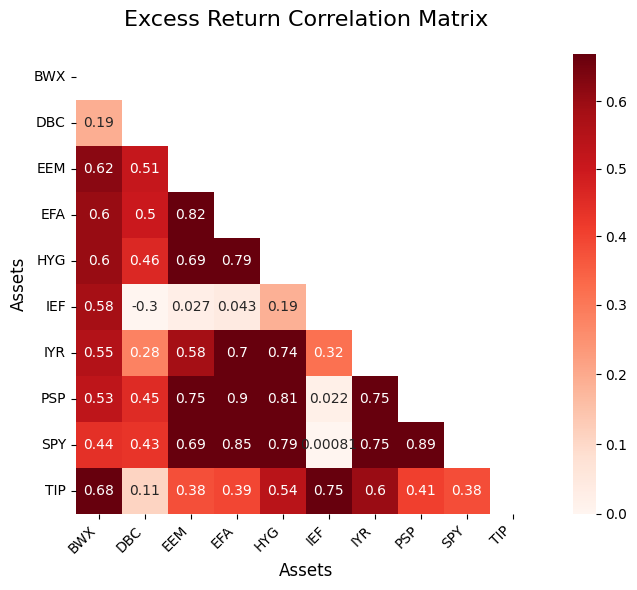

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
corr_matrix = df.corr()

"""
Copied from Mark's Notebook
"""

# Create figure with better styling
plt.figure(figsize=(8, 6))

# Set upper triangle and diagonal to NaN for cleaner visualization
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.copy()
corr_matrix_masked[mask.astype(bool)] = np.nan

# Set up color normalization
center = 0.33
vmin = 0
vmax = 0.67
norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

# Create heatmap
sns.heatmap(corr_matrix_masked,
            annot=True,# No annotations
            norm=norm,
            cmap='Reds',
    cbar=True,
    square=True)

plt.title('Excess Return Correlation Matrix', fontsize=16, pad=20)
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Assets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
corr = df.corr()

stacked = corr.stack()            # turns into long series (row, col) → value
filtered = stacked[stacked < 1]   # drop diagonal = 1
max_val = filtered.max()
min_val = filtered.min()
max_idx = filtered.idxmax()
min_idx = filtered.idxmin()
print(max_val)
print(max_idx)
print(min_idx)
print(min_val)

0.8953201243752301
('EFA', 'PSP')
('DBC', 'IEF')
-0.30020714105644963


In [ ]:
# R = T x N matrix of excess returns
R = df.values
y = np.ones(R.shape[0])

# OLS solution from classs using mark's trick
beta = np.linalg.inv(R.T @ R) @ (R.T @ y)

# Normalize so weights sum to 1
w_reg = beta / beta.sum()


wt_reg = pd.Series(w_reg, index=df.columns)
print("Tangency Portfolio Weights (via regression trick):")
print(wt_reg.sort_values(ascending=False))

# annualize mean/covariance
mu = df.mean() * 12
Sigma = df.cov() * 12

#
w_mv = np.linalg.inv(Sigma.values) @ mu.values
w_mv = w_mv / w_mv.sum()

print("\nDo the regression and tangency weights match?")
print(np.allclose(wt_reg.values, w_mv, rtol=1e-5))

Tangency Portfolio Weights (via regression trick):
SPY    1.059632
IEF    0.881186
HYG    0.290614
TIP    0.175293
EFA    0.068682
EEM    0.026437
DBC   -0.071623
IYR   -0.246582
PSP   -0.332995
BWX   -0.850643
dtype: float64

Do the regression and tangency weights match?
True


In [ ]:

# Baseline tangency portfolio (with TIPS as-is
w_base = np.linalg.inv(Sigma.values) @ mu.values
w_base = w_base / w_base.sum()
port_mean_base = w_base @ mu
port_vol_base  = np.sqrt(w_base @ Sigma.values @ w_base)
port_sharpe_base = port_mean_base / port_vol_base

# Tangency portfolio WITHOUT TIPS
mu_no_tips = mu.drop("TIP")
Sigma_no_tips = Sigma.drop(index="TIP", columns="TIP")

w_no_tips = np.linalg.inv(Sigma_no_tips.values) @ mu_no_tips.values
w_no_tips = w_no_tips / w_no_tips.sum()
port_mean_no = w_no_tips @ mu_no_tips
port_vol_no  = np.sqrt(w_no_tips @ Sigma_no_tips.values @ w_no_tips)
port_sharpe_no = port_mean_no / port_vol_no

# Tangency portfolio WITH adjusted TIPS return
mu_adj = mu.copy()
mu_adj["TIP"] = mu_adj["TIP"] + 0.0012

w_with_tips = np.linalg.inv(Sigma.values) @ mu_adj.values
w_with_tips = w_with_tips / w_with_tips.sum()
port_mean_with = w_with_tips @ mu_adj
port_vol_with  = np.sqrt(w_with_tips @ Sigma.values @ w_with_tips)
port_sharpe_with = port_mean_with / port_vol_with

print("Baseline Tangency Portfolio (with TIPS")
print(pd.Series(w_base, index=mu.index).sort_values(ascending=False))
print(f"Mean: {port_mean_base:.4f}, Vol: {port_vol_base:.4f}, Sharpe: {port_sharpe_base:.4f}\n")

print("Tangency Portfolio (WITHOUT TIPS")
print(pd.Series(w_no_tips, index=mu_no_tips.index).sort_values(ascending=False))
print(f"Mean: {port_mean_no:.4f}, Vol: {port_vol_no:.4f}, Sharpe: {port_sharpe_no:.4f}\n")

print("Tangency Portfolio (WITH Adjusted TIPS")
print(pd.Series(w_with_tips, index=mu_adj.index).sort_values(ascending=False))
print(f"Mean: {port_mean_with:.4f}, Vol: {port_vol_with:.4f}, Sharpe: {port_sharpe_with:.4f}")

Baseline Tangency Portfolio (with TIPS
SPY    1.059632
IEF    0.881186
HYG    0.290614
TIP    0.175293
EFA    0.068682
EEM    0.026437
DBC   -0.071623
IYR   -0.246582
PSP   -0.332995
BWX   -0.850643
dtype: float64
Mean: 0.1285, Vol: 0.0875, Sharpe: 1.4692

Tangency Portfolio (WITHOUT TIPS
SPY    1.100973
IEF    1.019957
HYG    0.316300
EFA    0.060153
EEM    0.032493
DBC   -0.063742
IYR   -0.247445
PSP   -0.339398
BWX   -0.879292
dtype: float64
Mean: 0.1327, Vol: 0.0905, Sharpe: 1.4675

Tangency Portfolio (WITH Adjusted TIPS
SPY    1.032299
IEF    0.789433
TIP    0.291192
HYG    0.273631
EFA    0.074321
EEM    0.022433
DBC   -0.076833
IYR   -0.246012
PSP   -0.328762
BWX   -0.831702
dtype: float64
Mean: 0.1261, Vol: 0.0856, Sharpe: 1.4724
